In [28]:
from sklearn.neighbors import BallTree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import unary_union
import numpy as np
import pandas as pd
import geopandas as gpd
def get_nearest_neighbors(gdf_obs, gdf_cand = None, k_neighbors=5):

    if gdf_cand is None:
        gdf_cand = gdf_obs 
    src_points = [(x,y) for x,y in zip(gdf_obs.geometry.x , gdf_obs.geometry.y)]
    candidates =  [(x,y) for x,y in zip(gdf_cand.geometry.x , gdf_cand.geometry.y)]

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='euclidean')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors+1)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    closest_gdfs = []
    for k in np.arange(k_neighbors):
        gdf_new = gdf_cand.iloc[indices[k+1]].reset_index()
        del gdf_new['index']
        gdf_new = gdf_new.add_suffix(f'_{k+1}')
        closest_gdfs.append(gdf_new)
        
    closest_gdfs.insert(0,gdf_obs)    
    gdf_final = pd.concat(closest_gdfs,axis=1)

    return gdf_final

def rfsi(gdf, k_neighbors=5, vname = '', ntrees = 150, bound_grid = None, grid_res = 10, grid_geom = 'Point', seed = None, folds = 5):
    # Definimos el nombre del target y el valor de k para k-nearest neighbors
    target = vname
    
    # Creamos el modelo de Random Forest
    random_forest_model = RandomForestRegressor(n_estimators=ntrees, random_state=seed)
    if isinstance(k_neighbors, list):
        print("Buscando el parametro optimo...")
        # Obtenemos los knn vecinos más cercanos
        gdf_nn = get_nearest_neighbors(gdf_obs=gdf,k_neighbors=max(k_neighbors))
        xv = pd.DataFrame(columns=['knn','rmse'])
        for j in k_neighbors:
            knn = j

            # Generamos automáticamente el nombre de las características basadas en el nombre del target y el valor de k
            features = [f'{target}_{i}' for i in range(1, knn + 1)]
            X = gdf_nn[features]
            y = gdf_nn[target]

            # Define los pliegues para la validación cruzada
            kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

            # Realiza la validación cruzada y obtiene las predicciones y los valores reales
            predictions = cross_val_predict(random_forest_model, X, y, cv=kf)

            # Crear un DataFrame con las columnas "Observado" y "Predicho"
            residuals = pd.DataFrame({'observado': y, 'predicho': predictions})

            # Calcular el RMSE utilizando los valores observados y predichos en el DataFrame
            rmse = np.sqrt(mean_squared_error(residuals['observado'], residuals['predicho']))

            #Registrar el valor de rmse
            #xv = pd.concat([xv, pd.DataFrame({'knn': [knn], 'rmse': [rmse]})], ignore_index=True)
            print("Numero vecinos testeado: ", knn, " - rmse resultante: ", round(rmse,3))
            xv.loc[len(xv)] = [knn, rmse]
        
        #Filtrar el menor rmse
        min_rmse = xv.loc[xv['rmse'].idxmin()]

        #Obtener el nuemro de vecinos optimo
        knn = int(min_rmse['knn'])
        rmse = min_rmse['rmse']
        print("Numero vecinos optimo: ", knn, " - rmse: ", round(rmse,3))
    elif isinstance(k_neighbors, int):
        knn = k_neighbors
        # Obtenemos los knn vecinos más cercanos
        gdf_nn = get_nearest_neighbors(gdf_obs=gdf,k_neighbors=knn)
        residuals = pd.DataFrame({'observado': [], 'predicho': []})
    else:
        return "Tipo de dato no soportado para k_neighbors"
    print("Obteniendo el modelo de prediccion...")
    # Generamos automáticamente el nombre de las características basadas en el nombre del target y el valor de k
    features = [f'{target}_{i}' for i in range(1, knn + 1)]
    X = gdf_nn[features]
    y = gdf_nn[target]

    # Entrena el modelo utilizando todos los datos
    random_forest_model.fit(X, y)

    if isinstance(bound_grid, gpd.GeoDataFrame):
        print("Prediciendo sobre la grilla...")
         # Crea una grilla de puntos con la resolucion especificada en grid_res dentro del área del polígono
        minx, miny, maxx, maxy = bound_grid.total_bounds
        x_coords = range(int(minx), int(maxx), grid_res)
        y_coords = range(int(miny), int(maxy), grid_res)
        
        # Crea una lista para almacenar los puntos de la grilla
        grid_points = []
        # Itera sobre cada coordenada en la grilla
        for x in x_coords:
            for y in y_coords:
                # Crea un punto con las coordenadas actuales
                point = Point(x + grid_res/2, y + grid_res/2)  # Usa el punto central de cada celda
                
                # Agrega el punto a la lista
                grid_points.append(point)
        """# Crea una lista para almacenar las celdas
        grid_cells = []
        for x in x_coords:
            for y in y_coords:
                # Crea el poligono con las coordenadas de la celda
                cell = Polygon([(x, y), (x + grid_res, y), (x + grid_res, y + grid_res), (x, y + grid_res)])
                # Agrega la celda a la lista
                grid_cells.append(cell)"""

        # Crea un GeoDataFrame a partir de la lista de puntos
        grid = gpd.GeoDataFrame(geometry=grid_points, crs=bound_grid.crs)

        # Intersecta la grilla con el polígono para eliminar las celdas que están fuera del perímetro
        intersect_grid = gpd.overlay(grid, bound_grid, how='intersection')

        # Obtenemos los vecinos mas cercanos de cada celda
        grid = get_nearest_neighbors(gdf_obs=intersect_grid, gdf_cand=gdf, k_neighbors=knn)


        # Aplica el modelo de Random Forest para predecir los valores sobre la grilla
        predict_grid = random_forest_model.predict(grid[features])

        # Agrega las predicciones como una nueva columna en el GeoDataFrame de la grilla
        intersect_grid['pred'] = predict_grid
        if grid_geom=='Polygon':
            grid_poly=[]
            for punto in intersect_grid['geometry']:
                x, y = punto.x, punto.y
                grid_poly.append(Polygon([(x-grid_res/2, y-grid_res/2), (x+grid_res/2, y-grid_res/2), (x+grid_res/2, y+grid_res/2), (x-grid_res/2, y+grid_res/2)]))
            intersect_grid = gpd.GeoDataFrame({'geometry': grid_poly, 'pred': intersect_grid['pred']})
    else:
        intersect_grid = gpd.GeoDataFrame(columns=['geometry','pred'], geometry='geometry')
    # Retorna el modelo entrenado, los residuales y la grilla interpolada
    return random_forest_model, intersect_grid, residuals

In [ ]:
obs = gpd.read_file(filename="Data/ECa.gpkg",layer="EC_field_04")
knn = 5
model, predictions, resid= rfsi(gdf=obs,k_neighbors=knn,vname='EC90',seed=701408733)

In [4]:
obs = gpd.read_file(filename="Data/ECa.gpkg",layer="EC_field_04")
bound = gpd.read_file(filename="Data/F05_boundary.gpkg")
knn = [5,10,15,20,25,30,35]
model, predictions, resid= rfsi(gdf=obs,k_neighbors=knn,vname='EC90',bound_grid=bound,seed=701408733)

Buscando el parametro optimo...
Numero vecinos testeado:  5  - rmse resultante:  3.354
Numero vecinos testeado:  10  - rmse resultante:  3.351
Numero vecinos testeado:  15  - rmse resultante:  3.346
Numero vecinos testeado:  20  - rmse resultante:  3.35
Numero vecinos testeado:  25  - rmse resultante:  3.349
Numero vecinos testeado:  30  - rmse resultante:  3.341
Numero vecinos testeado:  35  - rmse resultante:  3.34
Numero vecinos optimo:  35  - rmse:  3.34
Obteniendo el modelo de prediccion...
Prediciendo sobre la grilla...


In [29]:
obs = gpd.read_file(filename="Data/ECa.gpkg",layer="EC_field_04")
bound = gpd.read_file(filename="Data/F05_boundary.gpkg")
knn = 5
model, predictions, resid= rfsi(gdf=obs,k_neighbors=knn,vname='EC90',bound_grid=bound,grid_geom='Polygon',grid_res=10,seed=701408733)

Obteniendo el modelo de prediccion...
Prediciendo sobre la grilla...


In [27]:
print(predictions.columns)

Index(['geometry', 'centroid', 'pred'], dtype='object')


In [5]:
from shapely.geometry import Polygon

# Define la función para crear un polígono cuadrado alrededor de un punto
def pointtopoly(punto,res=10):
    x, y = punto.x, punto.y
    return Polygon([(x-res/2, y-res/2), (x+res/2, y-res/2), (x+res/2, y+res/2), (x-res/2, y+res/2)])

# Crea una lista de polígonos cuadrados alrededor de cada punto de la grilla de puntos
grid_poligonos = [pointtopoly(punto) for punto in predictions['geometry']]

# Crea un nuevo GeoDataFrame con los polígonos y las predicciones asociadas a cada punto
grid_predicciones = gpd.GeoDataFrame({'geometry': grid_poligonos, 'pred': predictions['pred']})


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


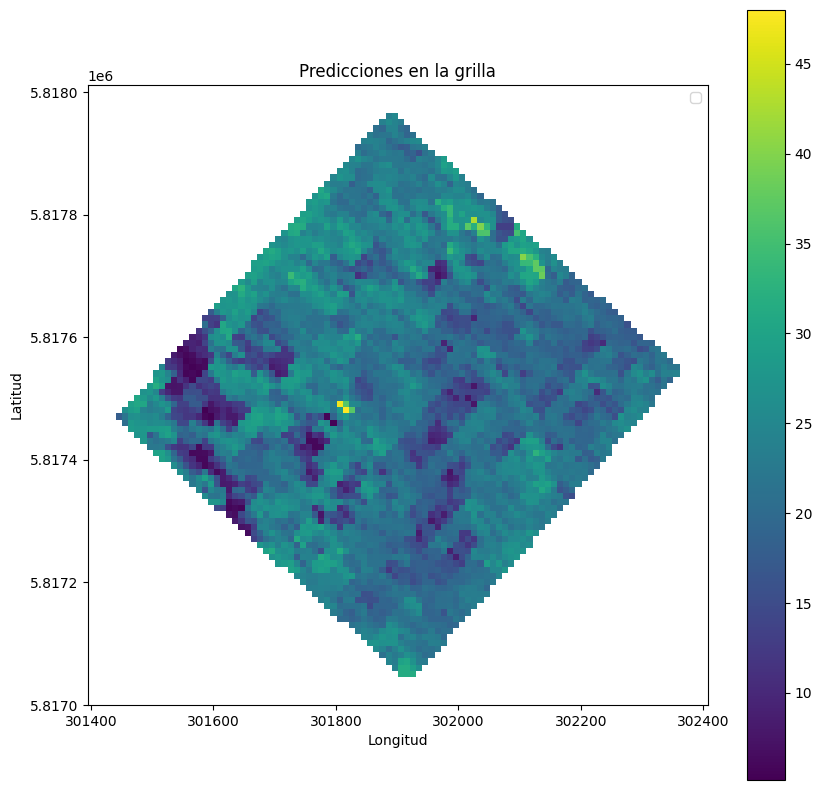

In [30]:
import matplotlib.pyplot as plt

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(10, 10))

# Plotear la grilla con las predicciones
predictions.plot(ax=ax, column='pred', cmap='viridis', legend=True)

# Añadir título y etiquetas
ax.set_title('Predicciones en la grilla')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
